In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

<AxesSubplot:xlabel='time'>

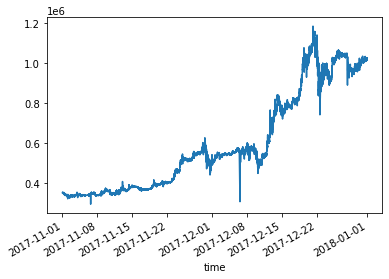

In [25]:
DATA_PATH = '/aiffel/aiffel/Time Series/fnguide/data/'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()


# Data Labeling

In [6]:
# change direction

window = 10

momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)


momentum_signal.value_counts()


1.0    521842
0.0    478148
Name: close, dtype: int64

time
2017-11-21 00:00:00    399150
2017-11-21 00:01:00    399050
2017-11-21 00:02:00    399050
2017-11-21 00:03:00    399000
2017-11-21 00:04:00    398900
                        ...  
2017-11-21 23:55:00    397850
2017-11-21 23:56:00    398050
2017-11-21 23:57:00    397150
2017-11-21 23:58:00    397250
2017-11-21 23:59:00    397600
Name: close, Length: 1301, dtype: int64
time
2017-11-21 00:00:00    0.0
2017-11-21 00:01:00    0.0
2017-11-21 00:02:00    0.0
2017-11-21 00:03:00    0.0
2017-11-21 00:04:00    0.0
                      ... 
2017-11-21 23:55:00    0.0
2017-11-21 23:56:00    0.0
2017-11-21 23:57:00    0.0
2017-11-21 23:58:00    0.0
2017-11-21 23:59:00    0.0
Name: close, Length: 1301, dtype: float64


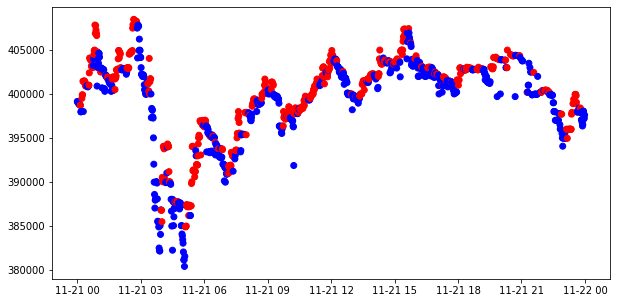

In [7]:
sub_data = modify_data.loc['2017-11-21', 'close']

print(sub_data)
c_sig = s_momentum_signal.loc['2017-11-21']

print(c_sig)

c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10, 5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [8]:
# moving average

momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)


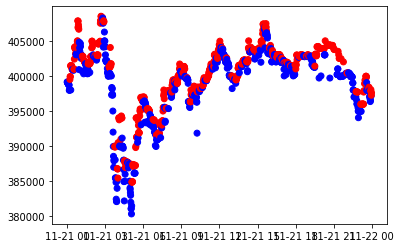

In [9]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [17]:
# local min max

def get_local_min_max(close, wait = 3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes , max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
            
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
                
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
                
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})



In [19]:
mins, maxes = get_local_min_max(sub_data)
mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


In [20]:
maxes

,max_time,local_max
0,2017-11-21 00:13:00,399500
1,2017-11-21 00:14:00,399900
2,2017-11-21 00:16:00,401450
3,2017-11-21 00:19:00,401350
4,2017-11-21 00:20:00,401500
...,...,...
268,2017-11-21 23:41:00,398050
269,2017-11-21 23:43:00,398400
270,2017-11-21 23:46:00,398200
271,2017-11-21 23:47:00,398400


(376546.5, 412585.0)

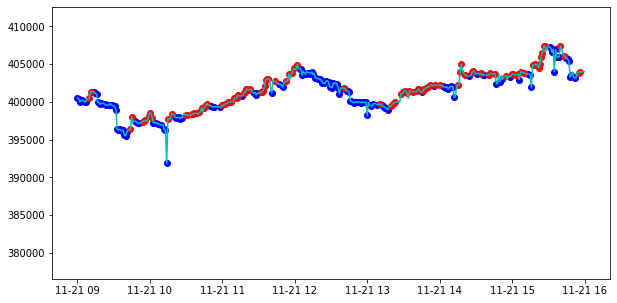

In [21]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(sub_data.loc[st_time : ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')

ax.set_ylim([sub_data.min() * 0.99 , sub_data.max() * 1.01])


In [22]:
mins.shape[0], maxes.shape[0]

(477, 273)

In [30]:
# trend scanning

def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t val from linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [31]:
look_fwd_window = 60
min_sample_len = 5
step = 1
t1_array = []
t_values_array = []

In [33]:
# not run
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index = molecule, columns = ['t1', 't_val', 'bin'])
tmp_out = []

for idx in tqdm(molecule):
    subset = modify_data.loc[idx: , 'close'].iloc[:look_fwd_window]
    if look_fwd_window > subset.shape[0]:
        continue
        
    tmp_subset = pd.Series(index=subset.index[min_sample_len -1 : subset.shape[0] -1])
    tval = []
    
    for fwd_window in np.arange(min_sample_len , subset.shape[0]):
        df = subset.iloc[:fwd_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])    
        
label.loc[molecule] = np.array(tmp_out)

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast = 'signed')

        
        

100%|██████████| 33384/33384 [14:34<00:00, 38.19it/s]


In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])


# Feature Engineering

In [3]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28907 sha256=22afd312de5696e555d9837fd7025b4bcf4924ca9fcaa53ff0badfa8b5d96a35
  Stored in directory: /aiffel/.cache/pip/wheels/d1/3c/c4/176cfd752bd625c697799269715459e85c6dfd9500df26ad93
Successfully built ta
     |████████████████████████████████| 535 kB 6.7 MB/s            


In [35]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/Time Series/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier


In [36]:
DATA_PATH = '/aiffel/aiffel/Time Series/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')


In [39]:
data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
label = pd.read_pickle(anno_file_name)
sub_data = data.loc[label.index]

sub_data = sub_data.iloc[:1000]

In [40]:
sub_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [41]:
label.head(), label.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [42]:
label.value_counts()

-1.0    306636
-0.0    302963
 1.0    299289
Name: t_value, dtype: int64

# Technical Index

- Add tech indexes to the dataset
- PNL, volatility -> standardize -> fit_transform -> model

In [44]:
mt = 1
fillna = False
df_ = sub_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

####### Volume Index

# Chaikin Money Flow
df_['volume_cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high = df_[high],
                                                       low = df_[low],
                                                       close = df_[close],
                                                       volume = df_[volume],
                                                       window = 20 * mt,
                                                       fillna = fillna
                                                       ).chaikin_money_flow()

# Force Index
df_['volume_fi'] = ta.volume.ForceIndexIndicator(close = df_[close],
                                                volume = df_[volume],
                                                window = 15 * mt,
                                                fillna = fillna
                                                ).force_index()

# Money Flow Indicator
df_['volume_mfi'] = ta.volume.MFIIndicator(high = df_[high],
                                          low = df_[low],
                                          close = df_[close],
                                          volume = df_[volume],
                                          window = 15 * mt,
                                          fillna = fillna
                                          ).money_flow_index()

# Ease of Moment
df_['volume_sma_em'] = ta.volume.EaseOfMovementIndicator(high = df_[high],
                                                        low = df_[low],
                                                        volume = df_[volume],
                                                        window = 15 * mt,
                                                        fillna = fillna
                                                        ).sma_ease_of_movement()

# Volume Price Trend
df_['volume_vpt'] = ta.volume.VolumePriceTrendIndicator(close = df_[close],
                                                       volume = df_[volume],
                                                       fillna = fillna
                                                       ).volume_price_trend()

###### Volatility Index

# Average True Range
df_['volt_atr'] = ta.volatility.AverageTrueRange(close = df_[close],
                                                high = df_[high],
                                                low = df_[low],
                                                window = 10 * mt,
                                                fillna = fillna
                                                ).average_true_range()

# Ulcer Index
df_['volt_ui'] = ta.volatility.UlcerIndex(close = df_[close],
                                         window = 15 * mt,
                                         fillna = fillna
                                         ).ulcer_index()

####### Trend Index

# MACD
df_['trend_macd_diff'] = ta.trend.MACD(close = df_[close],
                                 window_slow = 25 * mt,
                                 window_fast = 10 * mt,
                                 window_sign = 9,
                                 fillna = fillna
                                 ).macd_diff()

# Average Directional Mvmt Index
df_['trend_adx'] = ta.trend.ADXIndicator(high = df_[high],
                                        low = df_[low],
                                        close = df_[close],
                                        window = 15 * mt,
                                        fillna = fillna
                                        ).adx()

# TRIX Indicator
df_['trend_trix'] = ta.trend.TRIXIndicator(close = df_[close],
                                          window = 15 * mt,
                                          fillna = fillna
                                          ).trix()

# Mass Index
df_['trend_mass_idx'] = ta.trend.MassIndex(high = df_[high],
                                          low = df_[low],
                                          window_fast = 10 * mt,
                                          window_slow = 25 * mt,
                                          fillna = fillna
                                          ).mass_index()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], 
                                                 window=20, 
                                                 fillna=fillna
                                                ).aroon_indicator()

######## momentum index

# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], 
                                               window=15*mt, 
                                               fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()


In [45]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volt_atr,volt_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_idx,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-35.0,41.083991,-87.5


In [46]:
# PNL, Volume

windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)
    
for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [47]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [50]:
df_tmp = df_.join(label).dropna()

print(label)
df_tmp

time
2018-01-01 00:00:00   -0.0
2018-01-01 00:01:00   -0.0
2018-01-01 00:02:00   -0.0
2018-01-01 00:03:00   -1.0
2018-01-01 00:04:00   -1.0
                      ... 
2019-11-03 10:29:00    NaN
2019-11-03 10:30:00    NaN
2019-11-03 10:31:00    NaN
2019-11-03 10:32:00    NaN
2019-11-03 10:33:00    NaN
Name: t_value, Length: 908917, dtype: float64


,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,t_value
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1017500,1019000,1017500,1018500,30.272135,0.363435,719.550725,56.072055,8.940793e+11,0.036253,...,-42.105263,-0.678913,0.000000,-0.318982,0.000000,-0.818597,0.004438,2348.636190,34.165561,1.0
2018-01-01 00:44:00,1018500,1021500,1018000,1021500,25.131162,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,...,-10.526316,-0.294524,0.007396,-0.266406,0.000490,-0.363379,0.006404,2465.217810,34.384398,1.0
2018-01-01 00:45:00,1021500,1022000,1020000,1020000,17.108609,0.365340,5589.204549,56.034287,3.376449e+12,0.048901,...,-27.777778,0.260837,0.001965,-0.341287,0.000981,-0.293731,0.006413,2505.453821,34.506907,1.0
2018-01-01 00:46:00,1020000,1025000,1019000,1025000,44.289130,0.358534,32571.260299,50.196394,2.908715e+12,0.191981,...,-0.000000,2.165060,0.008362,-0.091323,0.003918,-0.168955,0.010848,2848.118960,33.965563,1.0
2018-01-01 00:47:00,1020000,1020000,1019000,1019000,10.224255,0.327429,20831.661354,45.446741,-6.760619e+11,0.157254,...,-52.173913,0.547160,0.001474,-0.855580,0.000491,-0.723566,0.003447,2855.524994,34.696090,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,-0.000000,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354,0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,-62.500000,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774,0.0
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,-87.500000,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495,0.0


In [52]:
X, y = df_tmp.iloc[:, 5:-1], df_tmp.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index = X.index, columns = X.columns)

In [53]:
X_sc

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volt_atr,volt_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,-1.315704,-0.287078,0.964449,-0.694987,-0.028358,-1.154914,0.009347,1.119360,-0.213129,-1.070983,...,0.091216,1.457839,-0.290098,0.683646,-0.263339,0.809831,-0.049429,-0.113254,-0.671848,-1.323649
2018-01-01 16:36:00,-1.052102,-0.373901,0.756529,-0.671205,-0.202126,-0.951719,-0.032148,0.829596,-0.171873,-1.002590,...,-0.789172,-0.596892,-0.103629,-0.053926,-0.156305,0.255031,-0.320415,-0.504179,-0.686893,-1.747571
2018-01-01 16:37:00,-1.033515,-0.368059,1.141100,-1.437940,-0.221777,-1.025471,-0.056373,0.483158,-0.108723,-0.953990,...,-1.082014,-1.418785,-0.207305,-0.643426,-0.331387,0.033018,-0.365897,-0.660549,-0.702092,-1.748596


In [54]:
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

In [56]:
feat_imp = imp.mean_decrease_impurity(model, X.columns)
feat_imp

,mean,std
volume_cmf,0.047437,0.002279
volume_fi,0.043701,0.002112
volume_mfi,0.047391,0.002386
volume_sma_em,0.031909,0.001803
volume_vpt,0.024522,0.001785
volt_atr,0.083564,0.003284
volt_ui,0.048714,0.002279
trend_macd_diff,0.078772,0.003800
trend_adx,0.052875,0.002187
trend_trix,0.070585,0.003166


In [58]:
svc_rbf = SVC(kernel = 'rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen = cv)

feat_imp_mda


,mean,std
volume_cmf,0.037067,0.023459
volume_fi,-0.017726,0.014601
volume_mfi,-0.006653,0.028375
volume_sma_em,0.005815,0.013039
volume_vpt,0.006356,0.005110
volt_atr,0.152401,0.052183
volt_ui,-0.012878,0.023381
trend_macd_diff,0.090082,0.019433
trend_adx,0.047005,0.021197
trend_trix,0.018664,0.008363


In [63]:
def plot_feat_imp(imp_df, save_fig=False, output_path=None):
    # plot mean imp bars w std
    
    plt.figure(figsize=(10, imp_df.shape[0] / 5))
    imp_df.sort_values('mean', ascending=True, inplace=True)
    imp_df['mean'].plot(kind='barh', color='b', alpha=.25,
                       xerr=imp_df['std'], error_kw={'ecolor': 'r'})
    
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()
    

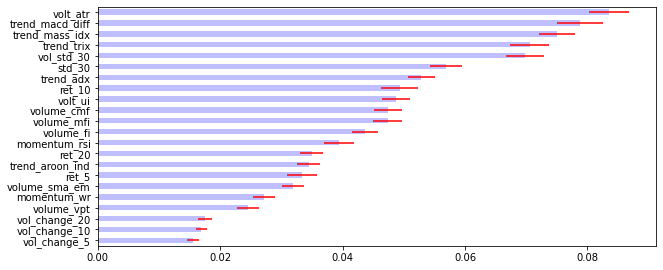

In [64]:
plot_feat_imp(feat_imp)

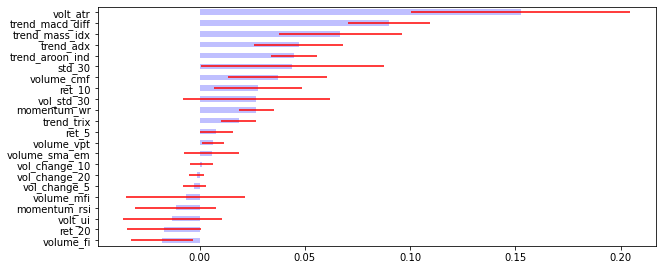

In [65]:
plot_feat_imp(feat_imp_mda)

## Sequential Feature Selection

In [66]:
# RFE CV (Recursive Feature Elimination)

svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [67]:
# Sequential Feature Selection (SFS)

sfs_fwd = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_fwd.fit(X_sc, y)




In [70]:
# Shapley

import shap

explainer = shap.TreeExplainer(model)
shap_val = explainer.shap_values(X_sc)

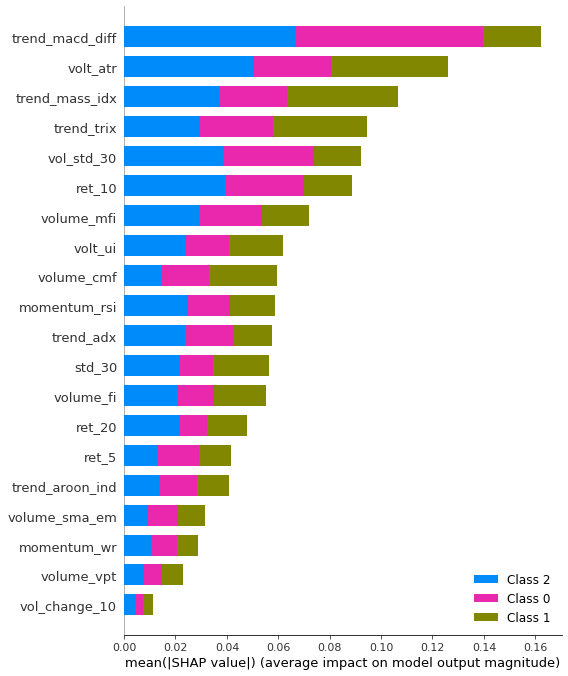

In [71]:
shap.summary_plot(shap_val, X_sc)

In [73]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp.to_pickle(output_file_name)


In [4]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/Time Series/fnguide/data/')
from libs.mlutil.pkfold import PKFold



In [5]:
DATA_PATH = '/aiffel/aiffel/Time Series/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')


In [6]:
df = pd.read_pickle(data_file_name)
df['t_value'] = df['t_value'].apply(lambda x: x if x == 1 else 0)


In [7]:
df

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,t_value
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1017500,1019000,1017500,1018500,30.272135,0.363435,719.550725,56.072055,8.940793e+11,0.036253,...,-42.105263,-0.678913,0.000000,-0.318982,0.000000,-0.818597,0.004438,2348.636190,34.165561,1.0
2018-01-01 00:44:00,1018500,1021500,1018000,1021500,25.131162,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,...,-10.526316,-0.294524,0.007396,-0.266406,0.000490,-0.363379,0.006404,2465.217810,34.384398,1.0
2018-01-01 00:45:00,1021500,1022000,1020000,1020000,17.108609,0.365340,5589.204549,56.034287,3.376449e+12,0.048901,...,-27.777778,0.260837,0.001965,-0.341287,0.000981,-0.293731,0.006413,2505.453821,34.506907,1.0
2018-01-01 00:46:00,1020000,1025000,1019000,1025000,44.289130,0.358534,32571.260299,50.196394,2.908715e+12,0.191981,...,-0.000000,2.165060,0.008362,-0.091323,0.003918,-0.168955,0.010848,2848.118960,33.965563,1.0
2018-01-01 00:47:00,1020000,1020000,1019000,1019000,10.224255,0.327429,20831.661354,45.446741,-6.760619e+11,0.157254,...,-52.173913,0.547160,0.001474,-0.855580,0.000491,-0.723566,0.003447,2855.524994,34.696090,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,-0.000000,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354,0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,-62.500000,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774,0.0
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,-87.500000,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495,0.0


In [8]:
df['t_value'].value_counts()

1.0    481
0.0    476
Name: t_value, dtype: int64

In [9]:
train_ratio , test_ratio = 0.7, 0.2

n_train = int(np.round(len(df) * train_ratio))
n_test = int(np.round(len(df) * test_ratio))

In [10]:
X, y = df.iloc[:, 5:-1], df.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = X_sc[:n_train, :] , X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]
    
X_train = pd.DataFrame(X_train, index=y_train.index, columns = X.columns)
X_test = pd.DataFrame(X_test, index=y_test.index, columns = X.columns)
y_train = pd.DataFrame(y_train, index=y_train.index)
y_test = pd.DataFrame(y_test, index=y_test.index)
    
X_train = X_train[:1000]
y_train = y_train[:1000]


In [13]:
# Purged K Fold

n_cv = 4
t1 = pd.Series(y_train.index.values, index=y_train.index)

print(t1)

cv = PKFold(n_cv, t1, 0)

time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...        
2018-01-01 11:48:00   2018-01-01 11:48:00
2018-01-01 11:49:00   2018-01-01 11:49:00
2018-01-01 11:50:00   2018-01-01 11:50:00
2018-01-01 11:51:00   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: datetime64[ns]


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
# GridSearch CV

bc_params = {'n_estimators': [5, 10, 20],
            'max_features' : [0.5, 0.7],
            'base_estimator__max_depth': [3, 5, 10, 20],
            'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(X_train, y_train)

gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [17]:
gs_rfc_best.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=10),
                  max_features=0.7)

In [18]:
y_pred = gs_rfc_best.predict(X_test)
y_prob = gs_rfc_best.predict_proba(X_test)

In [19]:
confusion = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[79 57]
 [13 42]]
정확도:0.6335078534031413, 정밀도:0.42424242424242425, 재현율:0.7636363636363637


auc:0.67225935828877


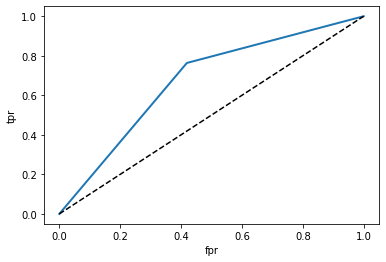

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')

print(f'auc:{auc}')